# We import the libraries

In [1]:
import numpy as np

from tsp_genetic import TSP_Genetic
from parent_selection import parent_selection
from mutation import mutation
from crossover import crossover

# Functions

In [2]:
def read_data(filepath):
    """ Read the data from the file and return the distance matrix and the list of cities positions """

    with open(filepath, 'r') as file:
        distance_matrix = False
        city_list = False
        for line in file:
            line = line.strip()
            # Create the distance matrix and the list of cities
            if line.startswith('DIMENSION'):
                dimension = int(line.split()[-1])
                cities = np.zeros((dimension, 2))
                distances = np.zeros((dimension, dimension))
                i=0
                j=0
            
            # What do we do with the line
            if line.startswith('EDGE_WEIGHT_SECTION'):
                distance_matrix = True
                continue
            elif line.startswith('DISPLAY_DATA_SECTION'):
                distance_matrix = False
                city_list = True
                continue
            elif line.startswith('EOF'):
                break
            
            # Save data
            if distance_matrix:
                distances[i,] = [int(x) for x in line.split()]
                i += 1
            if city_list:
                cities[j,] = line.split()[-2:]
                j += 1
        
        return distances, cities

In [3]:
def create_population(size : int, cities : np.ndarray):
    """ Create the initial population """

    population = []
    for i in range(size):
        population.append(np.random.permutation(cities.shape[0]))
    
    return population

# Analysis

In [4]:
# We read the data:
distances,cities= read_data('bays29.tsp')

In [5]:
# Instantiate the genetic algorithm
genetic= TSP_Genetic(generations=100,
                    print_rate=10,
                    m_rate=0.05,
                    c_rate=0.8,
                    select_parents="tournament_selection",
                    tournament_size=5,
                    crossover="OX1",
                    crossover_call="(4, cities.shape[0] - 4)",
                    mutation="insertion",
                    elitism=3)


In [6]:
# Instantiate the genetic algorithm
genetic= TSP_Genetic(generations=100,
                    print_rate=10,
                    m_rate=0.05,
                    c_rate=0.8,
                    select_parents="tournament_selection",
                    tournament_size=5,
                    crossover="POS",
                    crossover_call="()",
                    mutation="exchange",
                    elitism=3)

In [7]:
# Create the population:
population = create_population(50, cities)

INFO:root:Generation 0 - Best cromosome: [ 5 11  9  4  0 10 22 18 20 14  6  1 21 17 16 23 24 15  7  2  8 27 13  3
 19 12 25 28 26], Best fitness: 5203.0


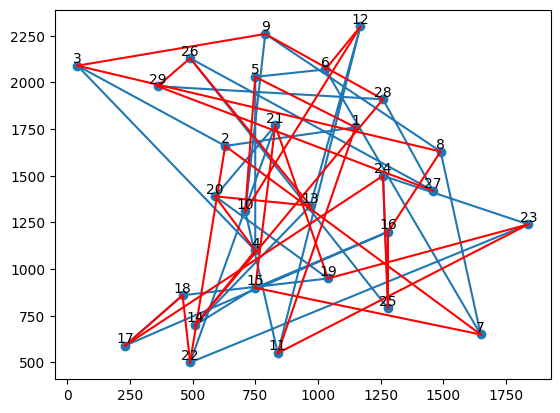

INFO:root:Generation 10 - Best cromosome: [ 5 11  9  4  0 10 22 18 13 14  6  1 21 17 16 23 24 15  7  2  8 27 20  3
 19 12 25 28 26], Best fitness: 4847.0


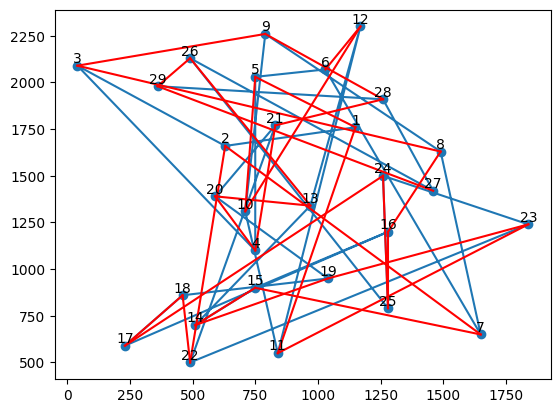

INFO:root:Generation 20 - Best cromosome: [ 5 11  9  4  0 10 22  6 13 14 18  1 21 17 16 23 24 15  7  2  8 27 20  3
 19 12 25 28 26], Best fitness: 4657.0


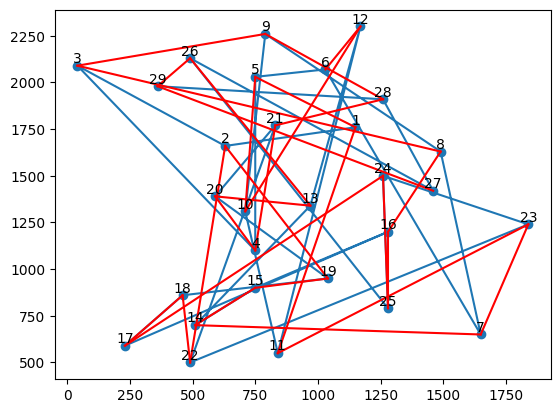

INFO:root:Generation 30 - Best cromosome: [27 11  9  4  0  7 22  6 13 14 19  3 21 17 16 23 24 15 10  2  8  5 20  1
 18 12 25 28 26], Best fitness: 4263.0


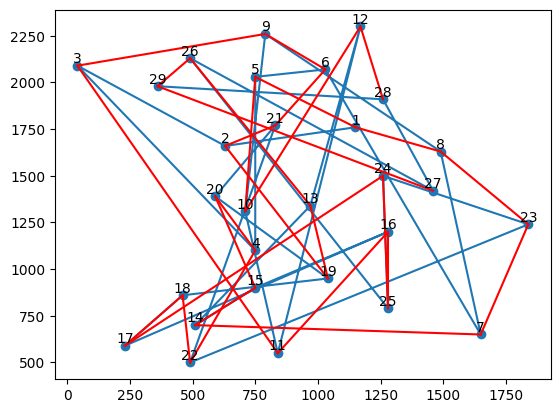

INFO:root:Generation 40 - Best cromosome: [27 11  9 12  0  7 22  6 13 14 19  3 21 17 16 23 24 15 10 28  8  5 20  1
 18  4 25  2 26], Best fitness: 3892.0


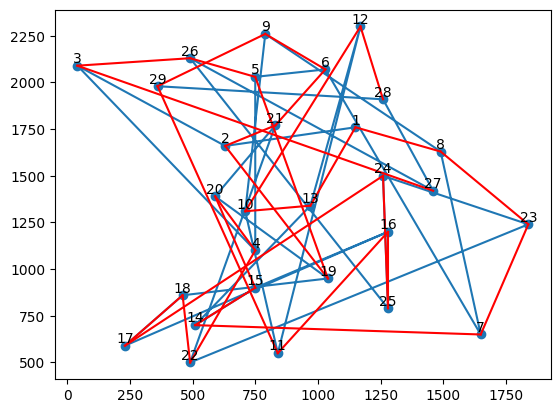

INFO:root:Generation 50 - Best cromosome: [27 11  9 12  0  7 22  6 13 14  3 19 21 17 16 23 24 15 10 26  8  5 20  1
 18  4 25 28  2], Best fitness: 3882.0


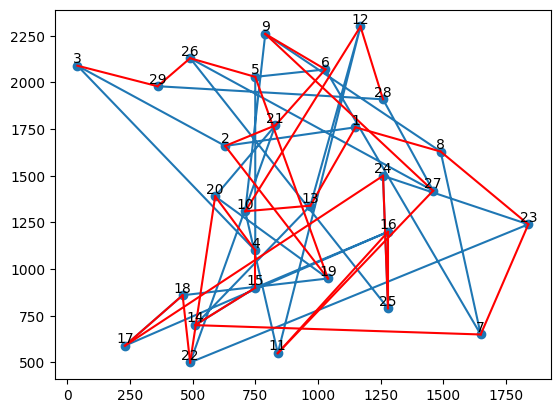

INFO:root:Generation 60 - Best cromosome: [27 11  9 12  0  7 22 10 13 14  3 19 21 17 16 23 24 15  6 26  8  5 20  1
 18  4 25 28  2], Best fitness: 3845.0


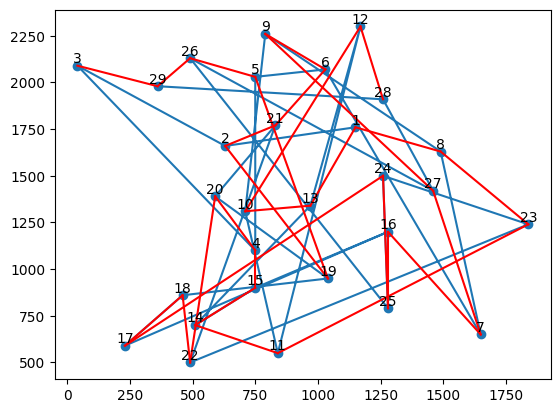

INFO:root:Generation 70 - Best cromosome: [27 11 19 12  0  7 22 10 13 14  3  9 21 17 16 23 24 15  6 26  8  5 20  1
 18  4 25 28  2], Best fitness: 3824.0


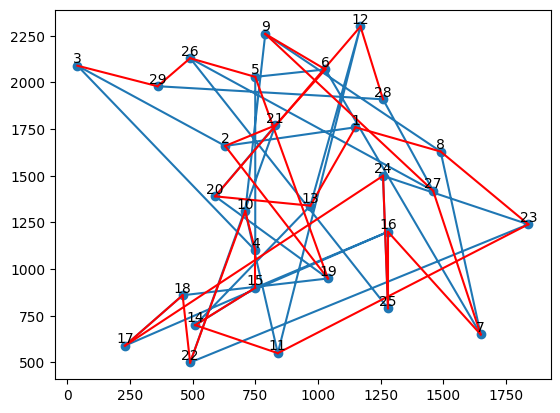

INFO:root:Generation 80 - Best cromosome: [27 11 19 12  0  7  6 10 13 14  3  9 21 17 16 23 24 15 22 26 18  5 20  1
  8  4 25 28  2], Best fitness: 3468.0


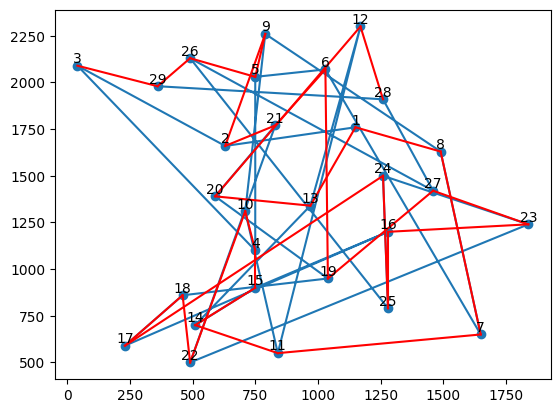

INFO:root:Generation 90 - Best cromosome: [27  1 19 12  0  7  6 10 13 14  3  9 21 17 16 23 24 15 18 26 22  5 20 11
  8  4 25 28  2], Best fitness: 3361.0


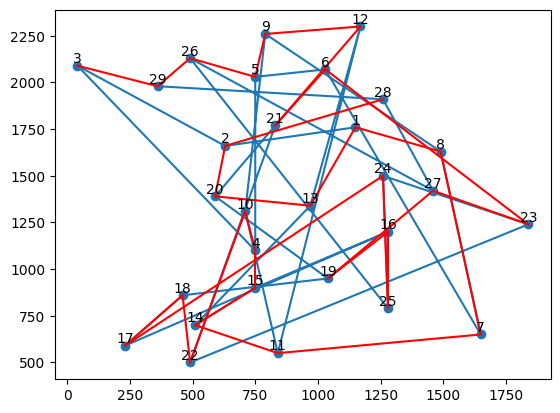

array([27,  5, 19, 12,  0,  7,  6, 10, 13, 14,  3,  9, 21, 17, 16, 23, 24,
       15, 18, 22, 26,  1, 20, 11,  8,  4, 25, 28,  2])

In [8]:
# Run the genetic algorithm
final_population = genetic.run(population,cities,distances)